In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.mixture import GaussianMixture
from matplotlib.colors import ListedColormap

In [ ]:
df = pd.read_csv('Mall_Customers.csv')
df.head(12)

,CustomerID,Genre,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40
5,6,Female,22,17,76
6,7,Female,35,18,6
7,8,Female,23,18,94
8,9,Male,64,19,3
9,10,Female,30,19,72


In [ ]:
df = df.drop(columns=['CustomerID'],axis=1)
# identify numeric coloumns and one hot encode
numerical_cols = df.select_dtypes(include=np.number).columns
df_encoded = pd.get_dummies(df, columns=['Genre'], drop_first=True)

In [ ]:
scaler = StandardScaler()
data_scaled = scaler.fit_transform(df_encoded)

In [ ]:
pca = PCA(n_components=2)
df_pca = pca.fit_transform(data_scaled)

# Create a DataFrame for the PCA results
df_pca = pd.DataFrame(data=df_pca, columns=['PC1', 'PC2'])

df_pca

,PC1,PC2
0,-0.406383,-0.520714
1,-1.427673,-0.367310
2,0.050761,-1.894068
3,-1.694513,-1.631908
4,-0.313108,-1.810483
...,...,...
195,-1.179572,1.324568
196,0.672751,1.221061
197,-0.723719,2.765010
198,0.767096,2.861930


In [ ]:
!pip install kneed==0.8.1

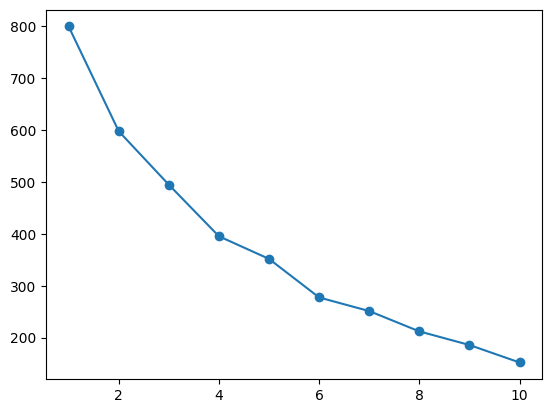

Optimal number of clusters (elbow point): 6


In [ ]:
inertia = []
k_range = range(1, 11)  # Test from 1 to 10 clusters
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(data_scaled)
    inertia.append(kmeans.inertia_)


plt.plot(range(1, 11), inertia, marker='o')
plt.show()
#done to know what is the most optimum k value, decided from the graph; most bend or elbow point
from kneed import KneeLocator
kneedle = KneeLocator(k_range, inertia, curve='convex', direction='decreasing')
optimal_k = kneedle.elbow
print(f"Optimal number of clusters (elbow point): {optimal_k}")

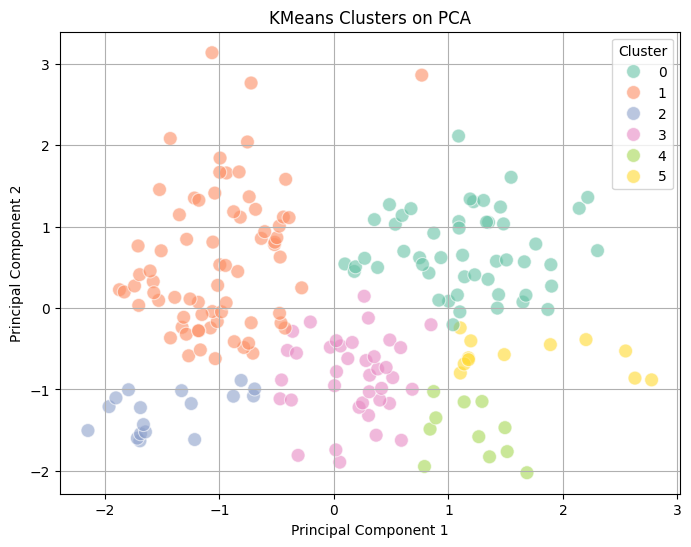

In [ ]:
kmean = KMeans(n_clusters=optimal_k, random_state=42)  # Use optimal_k
kmean.fit(df_pca)

# Get cluster labels from KMeans
df_pca['Cluster'] = kmean.labels_

plt.figure(figsize=(8, 6))
sns.scatterplot(x='PC1', y='PC2', hue='Cluster', data=df_pca, palette='Set2', s=100, alpha=0.6)
plt.title('KMeans Clusters on PCA')  # Changed title
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title='Cluster')
plt.grid(True)
plt.show()

In [ ]:
#model train with Agglomerative Hierarchical Clustering
from sklearn.cluster import AgglomerativeClustering

# Initialize the model
agg_clustering = AgglomerativeClustering(n_clusters=optimal_k)  # Using 3 clusters, as determined earlier

# Fit the model
agg_clustering.fit(df_pca)

# Get cluster assignments
df_pca['Agg_Cluster'] = agg_clustering.labels_

In [ ]:
#model train with gaussia mixture model
from sklearn.mixture import GaussianMixture

# Initialize the model
gmm = GaussianMixture(n_components=optimal_k, random_state=42)  # Using 3 components

# Fit the model
gmm.fit(df_pca)

# Get cluster assignments (predict the probabilities and assign to the most likely cluster)
df_pca['GMM_Cluster'] = gmm.predict(df_pca)

In [ ]:
#model train with BIRCH
from sklearn.cluster import Birch

# Initialize the model
birch = Birch(n_clusters=optimal_k)  # Using 3 clusters

# Fit the model
birch.fit(df_pca)

# Get cluster assignments
df_pca['BIRCH_Cluster'] = birch.labels_

In [ ]:
#compare results

from sklearn.metrics import silhouette_score, davies_bouldin_score

# Assuming you have your dataset and cluster assignments as described previously...

# Silhouette Score
kmeans_silhouette = silhouette_score(df_pca, df_pca['Cluster'])
agg_silhouette = silhouette_score(df_pca, df_pca['Agg_Cluster'])
gmm_silhouette = silhouette_score(df_pca, df_pca['GMM_Cluster'])
birch_silhouette = silhouette_score(df_pca,df_pca['BIRCH_Cluster'])

# Davies-Bouldin Index
kmeans_db = davies_bouldin_score(df_pca, df_pca['Cluster'])
agg_db = davies_bouldin_score(df_pca, df_pca['Agg_Cluster'])
gmm_db = davies_bouldin_score(df_pca, df_pca['GMM_Cluster'])
birch_db = davies_bouldin_score(df_pca, df_pca['BIRCH_Cluster'])

# Print the results
print("Silhouette Scores:")
print("KMeans:", kmeans_silhouette)
print("Agglomerative:", agg_silhouette)
print("GMM:", gmm_silhouette)
print("BIRCH:", birch_silhouette)

print("\nDavies-Bouldin Index:")
print("KMeans:", kmeans_db)
print("Agglomerative:", agg_db)
print("GMM:", gmm_db)
print("BIRCH:", birch_db)

Silhouette Scores:
KMeans: 0.5771524232956378
Agglomerative: 0.8059200624964276
GMM: 0.8059200624964276
BIRCH: 0.8059200624964276

Davies-Bouldin Index:
KMeans: 0.7849071338300506
Agglomerative: 0.2689398359758028
GMM: 0.26893983597580273
BIRCH: 0.2689398359758028


In [ ]:
#silhouette score->measures how similar a data point is to its own cluster
#higher value indicate better defined clusters (closer to 1)
#-> better is Agglomerative

#davies bouldin index->meausre avergae similarity between each cluster, lower indicates better(closer to 0)
#-> better is gmm

#final: Agglomerative, GMM, and BIRCH are the best-performing models having highest sillhoutte score, and has relatively low davies


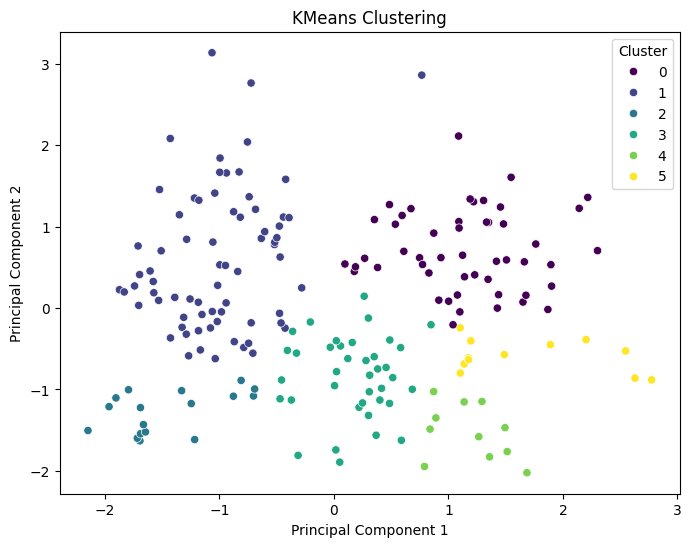

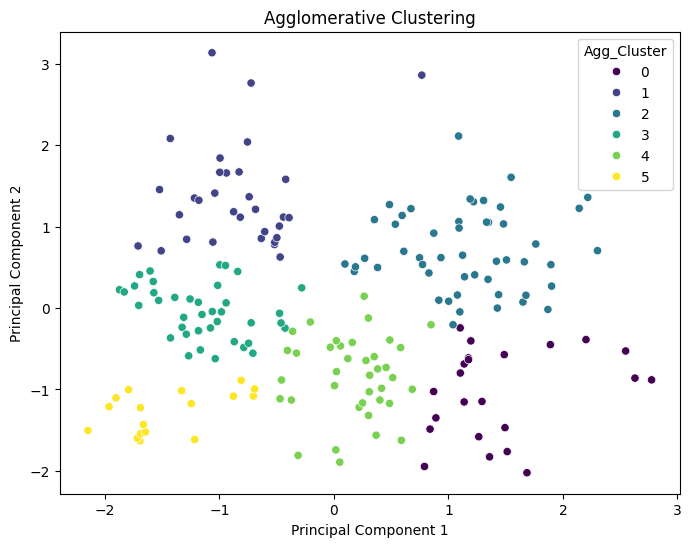

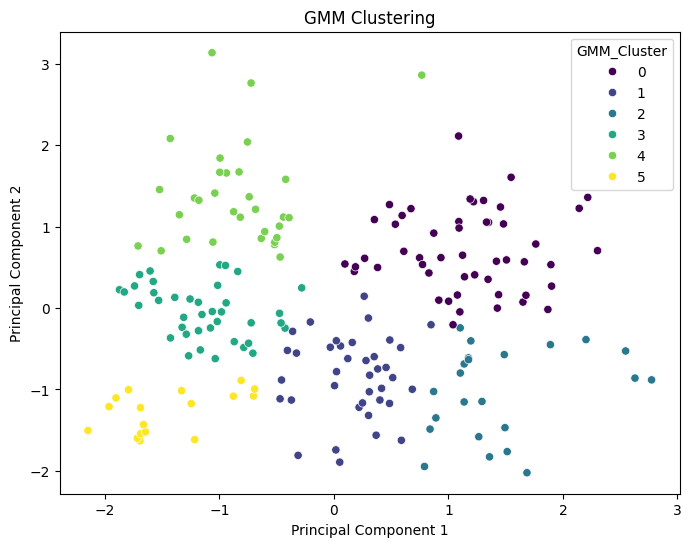

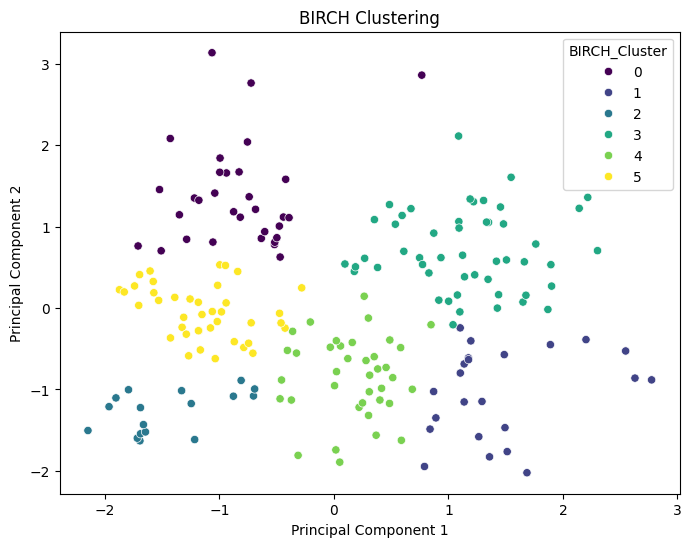

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming you have your dataset_pca DataFrame with cluster assignments

# KMeans Visualization
plt.figure(figsize=(8, 6))
sns.scatterplot(x='PC1', y='PC2', hue='Cluster', data=df_pca, palette='viridis')
plt.title('KMeans Clustering')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()

# Agglomerative Visualization
plt.figure(figsize=(8, 6))
sns.scatterplot(x='PC1', y='PC2', hue='Agg_Cluster', data=df_pca, palette='viridis')
plt.title('Agglomerative Clustering')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()

# GMM Visualization
plt.figure(figsize=(8, 6))
sns.scatterplot(x='PC1', y='PC2', hue='GMM_Cluster', data=df_pca, palette='viridis')
plt.title('GMM Clustering')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()

# BIRCH Visualization
plt.figure(figsize=(8, 6))
sns.scatterplot(x='PC1', y='PC2', hue='BIRCH_Cluster', data=df_pca, palette='viridis')
plt.title('BIRCH Clustering')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()

#help gouping, patterns, seing which model performed better by not overlapping the points, spot outliers

In [ ]:
# Customer Profiles for GMM
df1 = pd.DataFrame(data_scaled, columns=df_encoded.columns)
df1.head()
df1_pca = pca.transform(data_scaled) # Transform data_scaled to get PC1 and PC2 for df1
df1['GMM_Cluster'] = gmm.predict(df_pca)
cluster_centers = df1.groupby('GMM_Cluster').mean()
cluster_centers

,Age,Annual Income (k$),Spending Score (1-100),Genre_Male
GMM_Cluster,,,,
0,0.682501,0.483225,-0.734504,0.765532
2,-0.893495,-0.041414,0.671613,-0.282038
3,0.205291,-0.436216,-0.280537,-0.727361
4,0.166042,0.258303,0.086113,0.285701
5,-0.901094,-1.184420,0.928520,-0.886405


In [ ]:
#GMM
'''
Cluster 0 (Dark Purple) - Mature, Affluent Males Age: High (0.68σ) Income: Slightly above average (0.48σ) Spending: Low (-0.73σ) Gender: Mostly Male (0.77σ) Profile: Older males with moderate to high income but conservative spending habits. Suggested Action: Target with premium products and loyalty programs that reward their spending.

Cluster 2 (Green) - Young, Average Spenders Age: Young (-0.89σ) Income: Average (-0.04σ) Spending: High (0.67σ) Gender: Slightly Female (-0.28σ) Profile: Younger individuals with average income who are comfortable spending. Suggested Action: Introduce them to new products and trends, potentially with targeted discounts.

Cluster 3 (Yellow) - Middle-Aged, Budget-Conscious Females Age: Slightly above average (0.21σ) Income: Below average (-0.44σ) Spending: Below average (-0.28σ) Gender: Mostly Female (-0.73σ) Profile: Middle-aged females who are price-sensitive and prioritize value. Suggested Action: Offer discounts, promotions, and highlight value-for-money products.

Cluster 4 (Light Green) - Young Professionals Age: Slightly above average (0.17σ) Income: Slightly above average (0.26σ) Spending: Average (0.09σ) Gender: Slightly Male (0.29σ) Profile: Young professionals with moderate income and spending habits. Suggested Action: Offer a mix of products and services catering to their lifestyle and career aspirations.

Cluster 5 (Teal) - Young, Trend-Driven Females Age: Young (-0.90σ) Income: Very low (-1.18σ) Spending: Very high (0.93σ) Gender: Strongly Female (-0.89σ) Profile: Young females, likely students or recent graduates, who prioritize trends and are willing to spend despite lower income. Suggested Action: Offer trendy products, flexible payment options (like BNPL), and student discounts.
'''

In [ ]:
# Customer Profiles for birch
df1 = pd.DataFrame(data_scaled, columns=df_encoded.columns)
df1.head()
df1['Birch_Cluster'] = birch.labels_
cluster_centers = df1.groupby('Birch_Cluster').mean()
cluster_centers

,Age,Annual Income (k$),Spending Score (1-100),Genre_Male
Birch_Cluster,,,,
0,-0.561126,0.987729,0.910608,0.750423
1,1.177754,-0.756551,-1.061010,-0.360869
2,-0.901094,-1.184420,0.928520,-0.886405
3,0.682501,0.483225,-0.734504,0.765532
4,0.205291,-0.436216,-0.280537,-0.727361
5,-0.893495,-0.041414,0.671613,-0.282038


In [ ]:
#birch
'''
Cluster 0 (Dark Purple) - Affluent Young Males Age: Young (-0.56σ) Income: Very high (0.99σ) Spending: Very high (0.91σ) Gender: Mostly Male (0.75σ) Profile: Affluent young males with high spending habits. Likely interested in luxury goods and experiences. Suggested Action: Target with premium products, exclusive offers, and personalized experiences.

Cluster 1 (Teal) - Older, Budget-Conscious Age: High (1.18σ) Income: Below average (-0.76σ) Spending: Low (-1.06σ) Gender: Mostly Female (-0.36σ) Profile: Older individuals, primarily female, with lower income and conservative spending habits. Suggested Action: Focus on value-driven promotions, discounts, and essential products.

Cluster 2 (Green) - Young, Trend-Driven Females Age: Young (-0.90σ) Income: Very low (-1.18σ) Spending: Very high (0.93σ) Gender: Strongly Female (-0.89σ) Profile: Young females, likely students or recent graduates, who prioritize trends and experiences despite lower income. Suggested Action: Offer trendy products, flexible payment options, and student discounts.

Cluster 3 (Yellow) - Mature, Moderate Spenders Age: High (0.68σ) Income: Slightly above average (0.48σ) Spending: Low (-0.73σ) Gender: Mostly Male (0.77σ) Profile: Older individuals, primarily male, with moderate to high income but conservative spending habits. Suggested Action: Target with premium products and loyalty programs that reward spending over time.

Cluster 4 (Light Green) - Middle-Aged, Budget-Conscious Females Age: Slightly above average (0.21σ) Income: Below average (-0.44σ) Spending: Below average (-0.28σ) Gender: Mostly Female (-0.73σ) Profile: Middle-aged females who are price-conscious and prioritize value. Suggested Action: Offer discounts, promotions, and bundle deals on essential products.

Cluster 5 (Orange) - Young, Average Spenders Age: Young (-0.89σ) Income: Average (-0.04σ) Spending: High (0.67σ) Gender: Slightly Female (-0.28σ) Profile: Younger individuals with average income who are comfortable with spending. Suggested Action: Introduce them to new products and trends and offer targeted discounts.
'''

In [ ]:
# Customer Profiles for AGG
df1 = pd.DataFrame(data_scaled, columns=df_encoded.columns)
df1.head()

# For df1 prediction, extract features corresponding to 'PC1' and 'PC2'
df1_pca = pca.transform(data_scaled)  # Transform data_scaled to get PC1 and PC2 for df1

# Predict clusters for df1 using the fitted model
df1['Agg_Cluster'] = agg_clustering.fit_predict(df1_pca)
cluster_centers = df1.groupby('Agg_Cluster').mean()
cluster_centers

,Age,Annual Income (k$),Spending Score (1-100),Genre_Male
Agg_Cluster,,,,
0,-0.925464,-0.415214,0.978656,-0.428551
1,-0.563369,0.925473,0.980307,0.738238
2,0.091231,0.906258,-0.999479,0.639775
3,-0.196333,-0.287470,-0.088735,-0.598611
4,1.383031,-0.211065,-0.670084,0.517680
5,0.683578,-0.970839,-0.635380,-0.886405


In [ ]:
#agg
'''
Cluster 0 (Dark Purple) - Young, High Spenders Age: Young (-0.93σ) Income: Below Average (-0.42σ) Spending: Very High (0.98σ) Gender: Mostly Female (-0.43σ) Profile: Younger individuals, likely with lower income but high spending habits. Could be students or young adults prioritizing trends and experiences. Suggested Action: Offer trendy products, discounts, and flexible payment options to cater to their spending preferences.

Cluster 1 (Teal) - Affluent Young Spenders Age: Young (-0.56σ) Income: Very High (0.93σ) Spending: Very High (0.98σ) Gender: Mostly Male (0.74σ) Profile: Affluent young individuals, primarily male, with high spending habits. Likely interested in luxury goods and experiences. Suggested Action: Target with premium products, exclusive offers, and personalized experiences to cater to their high spending power.

Cluster 2 (Green) - Mature, Low Spenders Age: Slightly Above Average (0.09σ) Income: Very High (0.91σ) Spending: Very Low (-1.00σ) Gender: Mostly Male (0.64σ) Profile: Older individuals, mainly male, with high income but conservative spending habits. Could be retirees or those prioritizing savings over spending. Suggested Action: Focus on value-driven promotions, premium products with long-term value, and loyalty programs to reward their occasional purchases.

Cluster 3 (Yellow) - Average, Moderate Spenders Age: Slightly Below Average (-0.20σ) Income: Slightly Below Average (-0.29σ) Spending: Average (-0.09σ) Gender: Mostly Female (-0.60σ) Profile: Individuals with average income and moderate spending habits. Suggested Action: Offer a mix of products and services, focus on value and convenience, and potentially target with personalized recommendations based on their purchase history.

Cluster 4 (Light Green) - Older, Moderate Spenders Age: High (1.38σ) Income: Slightly Below Average (-0.21σ) Spending: Low (-0.67σ) Gender: Mostly Male (0.52σ) Profile: Older individuals with moderate income and lower spending habits. Could be retirees or those with fixed incomes. Suggested Action: Focus on essential products, discounts on everyday items, and loyalty programs to encourage repeat purchases.

Cluster 5 (Orange) - Mature, Low-Income, Low Spenders Age: High (0.68σ) Income: Very Low (-0.97σ) Spending: Low (-0.64σ) Gender: Strongly Female (-0.89σ) Profile: Older females with low income and conservative spending habits. Could be retirees or those on fixed incomes. Suggested Action: Focus on value-driven promotions, essential products, and discounts to cater to their budget constraints.
'''

In [ ]:
# Customer profiles for K-Means
df1 = pd.DataFrame(data_scaled, columns=df_encoded.columns)
df1.head()
df1['K.Means_Cluster'] = kmean.labels_
cluster_centers = df1.groupby('K.Means_Cluster').mean()
cluster_centers


,Age,Annual Income (k$),Spending Score (1-100),Genre_Male
K.Means_Cluster,,,,
0,0.682501,0.483225,-0.734504,0.765532
1,-0.745776,0.415983,0.777833,0.176833
2,-0.901094,-1.184420,0.928520,-0.886405
3,0.205291,-0.436216,-0.280537,-0.727361
4,1.080741,-0.992960,-0.950069,-0.886405
5,1.266682,-0.539843,-1.162706,0.120873


In [ ]:
#kmean
'''
Cluster 0 (Dark Purple) - Mature, Affluent Males Age: High (0.68σ) Income: Slightly above average (0.48σ) Spending: Low (-0.73σ) Gender: Mostly Male (0.77σ) Profile: Older males with moderate to high income but conservative spending habits. Suggested Action: Target with premium products and loyalty programs that reward their spending.

Cluster 1 (Teal) - Young, High Spenders Age: Young (-0.75σ) Income: Slightly above average (0.42σ) Spending: High (0.78σ) Gender: Slightly Male (0.18σ) Profile: Younger individuals, potentially with moderate income but high spending tendencies. Suggested Action: Offer trendy products, introduce new arrivals, and consider loyalty programs.

Cluster 2 (Green) - Young, Trend-Driven Females Age: Young (-0.90σ) Income: Very low (-1.18σ) Spending: Very high (0.93σ) Gender: Strongly Female (-0.89σ) Profile: Young females, likely students or recent graduates, prioritizing trends over savings. Suggested Action: Offer trendy products, flexible payment options (like BNPL), and student discounts.

Cluster 3 (Yellow) - Middle-Aged, Budget-Conscious Females Age: Slightly above average (0.21σ) Income: Below average (-0.44σ) Spending: Below average (-0.28σ) Gender: Mostly Female (-0.73σ) Profile: Middle-aged females who are price-sensitive and prioritize value. Suggested Action: Offer discounts, promotions, and highlight value-for-money products.

Cluster 4 (Light Green) - Older, Low-Income, Low Spenders Age: High (1.08σ) Income: Very low (-0.99σ) Spending: Low (-0.95σ) Gender: Strongly Female (-0.89σ) Profile: Older females with low income and conservative spending habits, possibly retirees. Suggested Action: Focus on value-driven promotions, essential products, and discounts to cater to budget constraints.

Cluster 5 (Orange) - Older, Low Spenders Age: High (1.27σ) Income: Below average (-0.54σ) Spending: Very Low (-1.16σ) Gender: Slightly Male (0.12σ) Profile: Older individuals, mostly male, with lower income and very conservative spending. Suggested Action: Focus on essential products, discounts, and potentially loyalty programs to encourage repeat purchases.
'''